<h1 style="text-align: center">TF4062: Introduction to finite element method</h1>
<h2 style="text-align: center">Iwan Prasetyo and Fadjar Fathurrahman</h2>




-------------------

In this notebook we will do some explorations with linear shape functions

We will mainly using SymPy module, so we import all symbols from this module.

In [1]:
from sympy import *

We will activate LaTeX for displaying SymPy outputs.

In [2]:
init_printing(use_latex=True)

Plotting stuffs. SymPy also can do it, however we would like to use NumPy + Matplotlib for plotting.

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import IPython.display
IPython.display.set_matplotlib_formats("svg")

Don't use this if you want to use the default style.

In [6]:
import matplotlib
matplotlib.style.use("dark_background")

-----------------

For general case of linear elements we have the following shape functions. For left
boundary points:
$$
N_{1}(x) = \begin{cases}
\dfrac{x_{2} - x}{h_1} & x_{1} \leq x \leq x_{2} \\[10pt]
0                     & \text{otherwise}
\end{cases}
$$

For interior points:

$$
N_{i}(x) = \begin{cases}
\dfrac{x - x}{h_{i-1}} & x_{i-1} \leq x \leq x_{i} \\[10pt]
\dfrac{x_{i+1} - x}{h_{i}} & x_{i} \leq x \leq x_{i+1},\quad i=2,3,\ldots,n \\[10pt]
0                     & \text{otherwise}
\end{cases}
$$

And for right boundary points:
$$
N_{n+1}(x) = \begin{cases}
\dfrac{x - x_{n}}{h_{n}} & x_{n} \leq x \leq x_{n+1} \\[10pt]
0                     & \text{otherwise}
\end{cases}
$$

where $h_{i}$ are the spacings between nodal points.
$$
h_{i} = x_{i+1} - x_{i}
$$

First we need to define grid points or mesh. For simplicity let's use two elements, or three nodal points (nodes).

Suppose that we will define our nodes or grid points within interval $[0,L]$.
For generality, we will describe $L$ as a symbolic object. We will also introduce $x$ as our symbolic variable for spatial variable.

In [7]:
L = Symbol("L", real=True, positive=True)
x = Symbol("x", real=True)

Here, we initialize our nodes and spacings. The nodes are in variable `xnodes` which is a list containing symbolic objects.

In [8]:
Nelements = 2
Npoints = Nelements + 1

xnodes = [Integer(0), L/2, L] # I use Integer(0) to make sure that all xnodes are SymPy objects
h = [xnodes[i+1]-xnodes[i] for i in range(Npoints-1)]

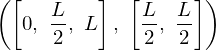

In [9]:
xnodes, h

Now we will begin defining our shape functions. Each shape function is defined as a piecewise function. In SymPy, we can define a piecewise function by using `Piecewise` class of SymPy.

In [10]:
cond1 = (x >= xnodes[0]) & (x <= xnodes[1])
f1 = (xnodes[1] - x)/h[0]
N_first = Piecewise( (f1, cond1), (0, True) )

The Piecewise object is need tuples of boolean and expression. For the first shape function, there are two conditions. We only specify one and the "otherwise" case is defined as `(0,True)`.

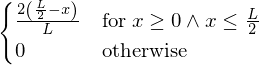

In [11]:
N_first

Here we define the second shape function. It needs three conditions, two conditions are defined with boolean expressions and the "otherwise" case as `(0,True)`.

In [12]:
cond1 = (x >= xnodes[0]) & (x <= xnodes[1])
f1 = ( x - xnodes[0])/h[0]
#
cond2 = (x >= xnodes[1]) & (x <= xnodes[2])
f2 = (xnodes[2] - x)/h[1]
#
N_second = Piecewise( (f1, cond1), (f2, cond2), (0, True) )

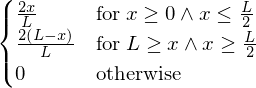

In [13]:
N_second

Now, we should be able to define the third (or last shape function) as follow. Note that I have used the variable `Npoints` instead of literal 3.

In [14]:
cond1 = (x >= xnodes[Npoints-2]) & (x <= xnodes[Npoints-1])
f1 = (x - xnodes[Npoints-2])/h[Npoints-2]
N_third = Piecewise( (f1, cond1), (0, True) )

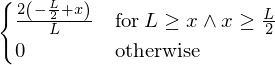

In [15]:
N_third

Now that we have defined the shape functions we wish to be able do something with them.

The first thing that we will try is to plot them. As our shape functions contains parameter $L$ and $x$ we should give them numerical values in order to be able to visualize them. This can be done by using the method `subs`. This method need a dictionary of symbol and the numerical value that we wish to substitute in the corresponding symbol.

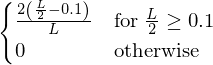

In [16]:
N_first.subs({x: 0.1})

In [17]:
N_first.subs({x: 0.1, L: 1.0})

In [18]:
N_first.subs({x: L/2})

In [19]:
N_second.subs({x: L/2})

In [20]:
Lnum = 1.0

In [21]:
num_dicts = {x: 1.0, L: Lnum}

In [22]:
N_third.subs(num_dicts)

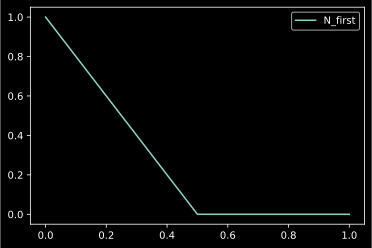

In [23]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt[ip] = N_first.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt, label="N_first")
plt.legend()

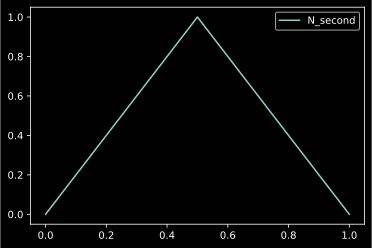

In [24]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt[ip] = N_second.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt, label="N_second")
plt.legend()

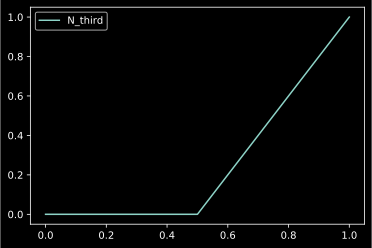

In [25]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt[ip] = N_third.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt, label="N_third")
plt.legend()

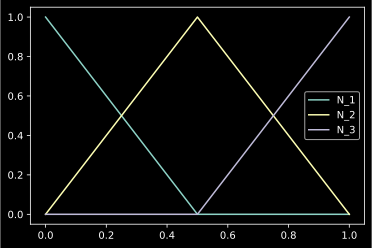

In [26]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt_1 = np.zeros(NptsPlot)
yplt_2 = np.zeros(NptsPlot)
yplt_3 = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt_1[ip] = N_first.subs( {x: xplt[ip], L: Lnum } )
    yplt_2[ip] = N_second.subs( {x: xplt[ip], L: Lnum } )
    yplt_3[ip] = N_third.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt_1, label="N_1")
plt.plot(xplt, yplt_2, label="N_2")
plt.plot(xplt, yplt_3, label="N_3")
plt.legend()

## Test integral

In the finite element methods, we need to be able to do calculate derivatives and integrals of our basis functions such as:

$$
\int_{0}^{L} N_{1}(x) N_{2}(x)\,\mathrm{d}x
$$

and 

$$
\int_{0}^{L} \frac{\mathrm{d} N_{1}(x)}{\mathrm{d}x} \frac{\mathrm{d} N_{2}(x)}{\mathrm{d}x} \,\mathrm{d}x
$$

The class `Integral` can be used to construct an evaluated integral (it is useful to displaying purpose). For example:

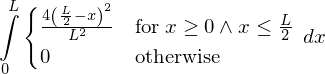

In [27]:
I1 = Integral(N_first*N_first, (x,0,L))
I1

To actually carry out the calculation we can call the method `doit()`.

In [28]:
I1.doit()

Alternatively, the function `integrate` can be used to calculate the integrals directly.

In [29]:
integrate(N_first*N_second, (x,0,L))

In [30]:
integrate(N_first*N_first, (x,0,L))

In [31]:
integrate(N_first*N_first, (x,0,L/2))

In [32]:
integrate(N_first*N_third, (x,0,L))

## Weak form

We assume that we have derived the weak form for our differential equation. For example:

$$
\int_{0}^{L} k
\left(
\frac{\mathrm{d} w(x)}{\mathrm{d}x}
\frac{\mathrm{d}T(x)}{\mathrm{d}x} \right)\, \mathrm{d}x -
\int_{0}^{L} w(x)\,Q\, \mathrm{d}x -
\left[ k\, w(x) \frac{\mathrm{d}T(x)}{\mathrm{d}x} \right]_{0}^{L} = 0
$$

We now wish to derive system of linear equations in terms of unknown nodal values of $T(x)$.

In [33]:
T = Function("T")(x)
w = Function("w")(x)
k = Symbol("k", real=True, positive=True)
Q = Symbol("Q", real=True)

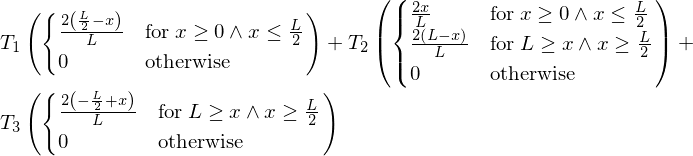

In [34]:
T_1 = Symbol("T_1", real=True)
T_2 = Symbol("T_2", real=True)
T_3 = Symbol("T_3", real=True)
T_expansion = T_1*N_first + T_2*N_second + T_3*N_third
T_expansion

In [35]:
T_expansion.subs({x: 0.1, L: Lnum})

Let's suppose that we want to derive the equation for $w(x) = N_{1}(x)$:

## Stiffness term or diffusion term

The first term:

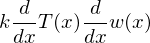

In [36]:
expr1 = k * Derivative(w,x) * Derivative(T, x)
expr1

We now do the following substitution:
- $T(x) \leftarrow \sum_{j=1}^{3} T_{j} N_{j}(x)$, and
- $w(x) \leftarrow N_{1}(x)$:

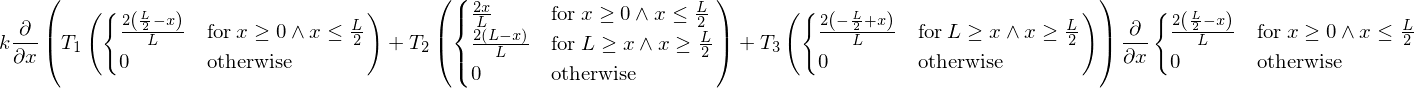

In [37]:
expr1s = expr1.subs({T: T_expansion, w: N_first})
expr1s

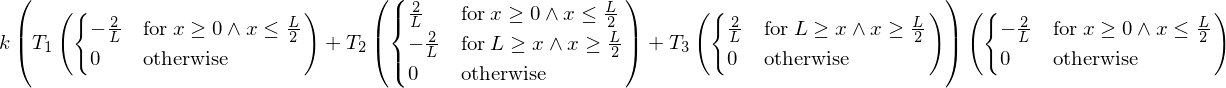

In [38]:
expr1ss = expr1s.doit()
expr1ss

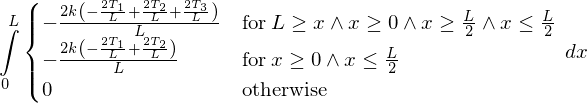

In [39]:
I1 = Integral(expr1ss, (x,0,L))
I1

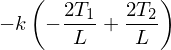

In [40]:
term1 = I1.doit()
term1

## Source term

In [41]:
expr2 = Integral( Q*w, (x,0,L) )
term2 = expr2.subs({w: N_first}).doit()
term2

## Boundary terms

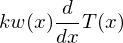

In [42]:
expr3 = k*w*Derivative(T,x)
expr3

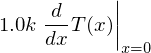

In [43]:
term3_x0 = expr3.subs({ w: N_first, x: 0, L: Lnum})
term3_x0

In [44]:
term3_xL = expr3.subs({ w: N_first, x: Lnum, L: Lnum})
term3_xL

## Overall contrib

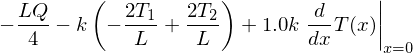

In [45]:
eq_first = term1 - term2 - (term3_xL - term3_x0)
eq_first

In [46]:
q0 = Symbol("q_0", real=True)

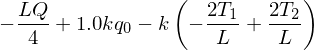

In [47]:
eq_first = eq_first.subs( {term3_x0.args[2]: q0} )
eq_first

## From the second second weight function

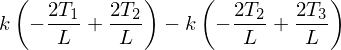

In [48]:
expr1s = expr1.subs({T: T_expansion, w: N_second})
expr1ss = expr1s.doit()
term1 = Integral(expr1ss, (x,0,L)).doit()
term1

In [49]:
term2 = expr2.subs({w: N_second}).doit()
term2

In [50]:
term3_x0 = expr3.subs({ w: N_second, x: 0, L: Lnum})
term3_x0

In [51]:
term3_xL = expr3.subs({ w: N_second, x: Lnum, L: Lnum})
term3_xL

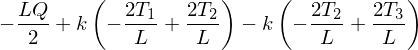

In [52]:
eq_second = term1 - term2 - (term3_xL - term3_x0)
eq_second

## Equation for third shape function

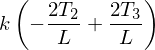

In [53]:
expr1s = expr1.subs({T: T_expansion, w: N_third})
expr1ss = expr1s.doit()
term1 = Integral(expr1ss, (x,0,L)).doit()
term1

In [54]:
term2 = expr2.subs({w: N_third}).doit()
term2

In [55]:
term3_x0 = expr3.subs({ w: N_third, x: 0, L: Lnum})
term3_x0

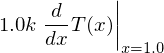

In [56]:
term3_xL = expr3.subs({ w: N_third, x: Lnum, L: Lnum})
term3_xL

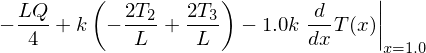

In [57]:
eq_third = term1 - term2 - (term3_xL - term3_x0)
eq_third

In [58]:
qL = Symbol("q_L", real=True)

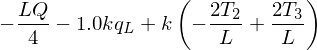

In [59]:
eq_third = eq_third.subs( {term3_xL.args[2]: qL} )
eq_third

# System of linear equations

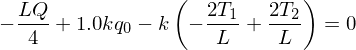

In [60]:
Equality( eq_first )

In [61]:
k

In [62]:
Q

In [110]:
num_dict = { L: Lnum, k: 1, Q: 1, q0: 1, qL: 0 }

In [111]:
linear_system = [eq_first.subs(num_dict), eq_second.subs(num_dict), eq_third.subs(num_dict)]
linear_system

In [112]:
linsolve(linear_system, T_1, T_2, T_3)

In [86]:
num_dict = { L: Lnum, k: 1, Q: 1, q0: 1, T_3: 10.0 }

In [87]:
linear_system = [eq_first.subs(num_dict), eq_second.subs(num_dict)]
linear_system

In [94]:
sols_lin = linsolve(linear_system, T_1, T_2)
sols_lin

In [98]:
sols_lin.args[0][1]

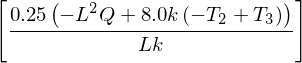

In [90]:
sols = solve(eq_third, qL)
sols

In [100]:
sols[0].subs(num_dict).subs({T_2: sols_lin.args[0][1]})

In [66]:
Eqns = [3*T_1 + 2*T_2 - T_3 - 1, 2*T_1 - 2*T_2 + 4*T_3 + 2, - T_1 + T_2/2 - T_3]
linsolve(Eqns, T_1, T_2, T_3)